# PM10 air pollution and deprivation in Leeds (LSOA 2011)

---

## 1. Background
Air pollution is a major public health issue in UK cities. Even within one local authority, pollution levels can vary a lot because of traffic, land use and local meteorology. At the same time, deprivation is not evenly distributed across a city.

In this notebook I look at a practical “public good” question:

> **Are higher PM10 concentrations in Leeds associated with more deprived neighbourhoods?**

I’m not trying to prove causation here. The goal is to produce a clear, reproducible analysis that can help discuss environmental inequality in a sensible way.

---

## 2. Research questions
1. **Where are higher PM10 areas within Leeds?** (spatial pattern)
2. **Do more deprived LSOAs tend to have higher PM10?** (simple statistical comparison)
3. **What are the main data limitations and biases in this approach?** (critical reflection)

---

## 3. Data (provided files)
This project uses three open datasets (provided as files):

1. **PM10 modelled grid (2021, annual mean)**: `mappm102021g.csv`  
  1 km grid points with OSGB coordinates (EPSG:27700) and PM10 values (µg m⁻³).
2. **Index of Multiple Deprivation (IMD)**: `imd_lsoa.csv`  
  LSOA 2011 codes, IMD rank and IMD decile, plus Local Authority name.
3. **LSOA 2011 boundaries (England & Wales, generalised)**: ZIP shapefile  
  LSOA polygons used for mapping and spatial aggregation.

We focus on **Leeds** by filtering the IMD table to the Leeds local authority and then subsetting the LSOA boundary file to those LSOA codes.

---

## 4. Reproducibility
- The notebook is designed to run in **Google Colab** or locally (Python 3).
- All file paths assume the three provided datasets are available in the working directory.


## 5. Setup: packages and paths

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)

# --- Input files (update names if yours differ) ---
PM10_CSV = "mappm102021g.csv"
IMD_CSV  = "imd_lsoa.csv"
LSOA_ZIP = "Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.zip"

# --- Working folders ---
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

## 6. Load IMD and define the Leeds study area

In [ ]:
# Read the IMD data and filter by Leeds; at the same time, convert Rank/Decile to numerical values ​​for easier statistics
imd = pd.read_csv(IMD_CSV)
imd.columns = [c.strip() for c in imd.columns]

# Clean IMD rank (stored with commas)
rank_col = "Index of Multiple Deprivation (IMD) Rank"
decile_col = "Index of Multiple Deprivation (IMD) Decile"
lsoa_col = "LSOA code (2011)"
lad_name_col = "Local Authority District name (2019)"

imd[rank_col] = imd[rank_col].astype(str).str.replace(",", "", regex=False)
imd[rank_col] = pd.to_numeric(imd[rank_col], errors="coerce")

imd[decile_col] = pd.to_numeric(imd[decile_col], errors="coerce")

# Filter to Leeds (Local Authority name)
imd_leeds = imd[imd[lad_name_col].str.strip().str.lower() == "leeds"].copy()

print("IMD rows (all):", len(imd))
print("IMD rows (Leeds):", len(imd_leeds))
imd_leeds[[lsoa_col, rank_col, decile_col]].head()

IMD rows (all): 32844
IMD rows (Leeds): 482


,LSOA code (2011),Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
10947,E01011264,13915,5
10948,E01011265,20368,7
10949,E01011266,29666,10
10950,E01011267,9111,3
10951,E01011268,6082,2


## 7. Load LSOA 2011 boundaries and subset to Leeds

The boundary file covers England & Wales. To keep things running smoothly, I only keep polygons whose **LSOA11 code** is in the Leeds IMD table.


In [ ]:
# Read the LSOA2011 boundary; then filter according to Leeds' LSOA code.
# Extract the shapefile from ZIP
extract_dir = os.path.join(DATA_DIR, "lsoa2011")
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(LSOA_ZIP, "r") as z:
    z.extractall(extract_dir)

# Find the .shp
shp_files = [f for f in os.listdir(extract_dir) if f.lower().endswith(".shp")]
print("Shapefiles:", shp_files)

lsoa_path = os.path.join(extract_dir, shp_files[0])
lsoa = gpd.read_file(lsoa_path)

print("LSOA polygons (EW):", len(lsoa))
print("Columns:", list(lsoa.columns))

Shapefiles: ['Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp']
LSOA polygons (EW): 34753
Columns: ['objectid', 'lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths', 'geometry']


In [ ]:
# Detect the LSOA code field in the shapefile
code_field = None
for c in ["LSOA11CD", "lsoa11cd", "LSOA_CODE", "code"]:
    if c in lsoa.columns:
        code_field = c
        break
if code_field is None:
    # fallback: first column containing 'CD'
    cd_like = [c for c in lsoa.columns if "CD" in c.upper()]
    code_field = cd_like[0] if cd_like else None
assert code_field is not None, "Could not find an LSOA code column in the shapefile."

# Subset to Leeds LSOAs
leeds_codes = set(imd_leeds[lsoa_col].unique())
lsoa_leeds = lsoa[lsoa[code_field].isin(leeds_codes)].copy()

# Ensure projected CRS for distance/area operations (usually already 27700 for these clipped boundaries)
if lsoa_leeds.crs is None:
    lsoa_leeds = lsoa_leeds.set_crs(27700)
else:
    lsoa_leeds = lsoa_leeds.to_crs(27700)

print("LSOA polygons (Leeds):", len(lsoa_leeds))
lsoa_leeds[[code_field, "geometry"]].head()

LSOA polygons (Leeds): 482


,lsoa11cd,geometry
10947,E01011264,"POLYGON ((421354.511 442329.064, 421423.385 44..."
10948,E01011265,"POLYGON ((418598.457 442763.114, 418637.341 44..."
10949,E01011266,"POLYGON ((417619.814 443438.73, 417810.54 4433..."
10950,E01011267,"POLYGON ((419594.66 442296.822, 419657.5 44227..."
10951,E01011268,"POLYGON ((420308.62 442015.353, 420322.625 441..."


## 8. Load PM10 grid (2021) and convert to points

The PM10 CSV contains a few header lines before the actual table. We:
- read the file
- use the first data row as column names
- convert x/y to a GeoDataFrame in EPSG:27700


In [ ]:
# Read PM10 1km grid data (2021 annual average)
pm10 = pd.read_csv(
    PM10_CSV,
    skiprows=5,        # Skip the first 5 lines of explanation
    header=0,          # The 6th row is used as column names.
    low_memory=False
)

# Column names should be in lowercase
pm10.columns = pm10.columns.str.lower()

pm10 = pm10.rename(columns={"pm102021g": "pm10_ugm3"})

# Convert to numerical type
pm10["x"] = pd.to_numeric(pm10["x"], errors="coerce")
pm10["y"] = pd.to_numeric(pm10["y"], errors="coerce")
pm10["pm10_ugm3"] = pd.to_numeric(pm10["pm10_ugm3"], errors="coerce")

# Remove missing values
pm10 = pm10.dropna(subset=["x", "y", "pm10_ugm3"]).copy()

print("PM10 grid points:", len(pm10))
pm10.head()


PM10 grid points: 254904


,gridcode,x,y,pm10_ugm3
0,55671,460500,1219500,3.647444
1,56360,459500,1218500,3.640125
2,56361,460500,1218500,3.649971
3,56362,461500,1218500,3.651860
4,56363,462500,1218500,3.653766


In [ ]:
# Convert the PM10 table to point data (EPSG:27700)
pm10_gdf = gpd.GeoDataFrame(
    pm10,
    geometry=gpd.points_from_xy(pm10["x"], pm10["y"]),
    crs=27700  # OSGB / British National Grid
)

# Clip to Leeds boundary (by intersecting points with Leeds LSOA polygons)
# This speeds up the join a lot.
pm10_leeds = gpd.sjoin(pm10_gdf[["pm10_ugm3", "geometry"]], lsoa_leeds[[code_field, "geometry"]],how="inner", predicate="within")

print("PM10 points inside Leeds LSOAs:", len(pm10_leeds))
pm10_leeds.head()

PM10 points inside Leeds LSOAs: 553


,pm10_ugm3,geometry,index_right,lsoa11cd
124959,12.13749,POINT (439500 449500),11346,E01011699
124960,11.54158,POINT (440500 449500),11347,E01011700
124961,14.21343,POINT (441500 449500),11351,E01011704
124962,12.39784,POINT (442500 449500),11351,E01011704
124963,11.86935,POINT (443500 449500),11344,E01011697


## 9. Aggregate PM10 to LSOA (mean per LSOA)

We calculate the **mean PM10** of all grid points that fall within each LSOA polygon.
This gives a neighbourhood-level PM10 estimate suitable for mapping and simple comparisons.


In [ ]:
# Aggregate grid points to LSOA: Calculate the average PM10 for each LSOA and combine it with the IMD index
pm10_by_lsoa = (
    pm10_leeds
    .groupby(code_field)["pm10_ugm3"]
    .mean()
    .reset_index()
    .rename(columns={"pm10_ugm3": "pm10_mean_ugm3"})
)

# Join to Leeds LSOA polygons
lsoa_leeds2 = lsoa_leeds.merge(pm10_by_lsoa, on=code_field, how="left")

# Join IMD decile/rank
imd_small = imd_leeds[[lsoa_col, rank_col, decile_col]].rename(columns={lsoa_col: code_field})
lsoa_leeds2 = lsoa_leeds2.merge(imd_small, on=code_field, how="left")

print("LSOAs with PM10:", lsoa_leeds2["pm10_mean_ugm3"].notna().sum(), "of", len(lsoa_leeds2))
lsoa_leeds2[["pm10_mean_ugm3", rank_col, decile_col]].describe()

LSOAs with PM10: 241 of 482


,pm10_mean_ugm3,Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile
count,241.000000,482.000000,482.000000
mean,12.168769,14058.024896,4.796680
std,1.366410,10160.311348,3.074973
min,9.177350,38.000000,1.000000
25%,11.303400,3789.250000,2.000000
50%,12.115340,14326.500000,5.000000
75%,13.107810,22774.750000,7.000000
max,15.547620,32664.000000,10.000000


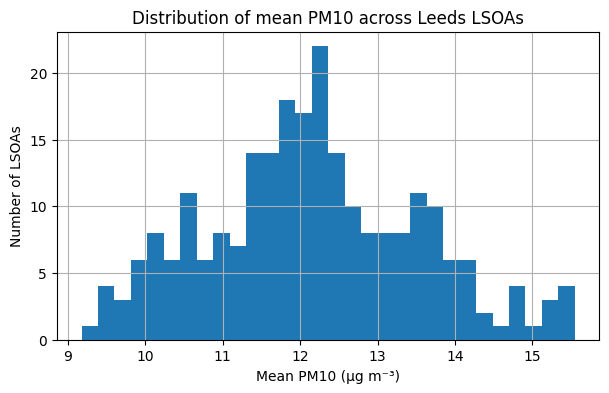

In [ ]:
# PM10 distribution histogram
# Check for outliers or obvious skewed distributions

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
lsoa_leeds2["pm10_mean_ugm3"].hist(bins=30, ax=ax)
ax.set_xlabel("Mean PM10 (µg m⁻³)")
ax.set_ylabel("Number of LSOAs")
ax.set_title("Distribution of mean PM10 across Leeds LSOAs")
plt.show()


In [ ]:
# Set negative values ​​as missing values.
neg_mask = lsoa_leeds2["pm10_mean_ugm3"].notna() & (lsoa_leeds2["pm10_mean_ugm3"] < 0)
if neg_mask.any():
    print("Found negative PM10 values. Setting them to NaN. Count:", int(neg_mask.sum()))
    lsoa_leeds2.loc[neg_mask, "pm10_mean_ugm3"] = np.nan

# Data quality check

s = lsoa_leeds2["pm10_mean_ugm3"]

print("PM10 summary (Leeds LSOAs):")
print(s.describe())
print("Missing PM10 LSOAs:", int(s.isna().sum()))
print("Negative PM10 LSOAs:", int((s.dropna() < 0).sum()))
print("Min PM10 (non-missing):", float(s.dropna().min()) if s.dropna().size else None)

PM10 summary (Leeds LSOAs):
count    241.000000
mean      12.168769
std        1.366410
min        9.177350
25%       11.303400
50%       12.115340
75%       13.107810
max       15.547620
Name: pm10_mean_ugm3, dtype: float64
Missing PM10 LSOAs: 241
Negative PM10 LSOAs: 0
Min PM10 (non-missing): 9.1773495


## 10. Exploratory checks

Before plotting, it helps to check:
- the PM10 range for Leeds
- whether any LSOAs have missing values (usually at the boundary)


In [ ]:
missing = lsoa_leeds2[lsoa_leeds2["pm10_mean_ugm3"].isna()]
print("Missing PM10 LSOAs:", len(missing))

lsoa_leeds2["pm10_mean_ugm3"].describe()

Missing PM10 LSOAs: 241


,pm10_mean_ugm3
count,241.000000
mean,12.168769
std,1.366410
min,9.177350
25%,11.303400
50%,12.115340
75%,13.107810
max,15.547620


## 11. Final visualisations

### 11.1 Spatial visualisation
**Audience:** local policymakers and public health teams.

**Design choices:**
- Choropleth at LSOA level shows neighbourhood variation clearly within one city.
- A single sequential colour scale is easy to interpret (“low → high” PM10).
- A clear title and legend support non-technical audiences.


**Note on audience:** I’m imagining this could be read by a local council/public health audience, so I try to keep the figures simple (clear legend, straightforward titles, no extra clutter).

### Audience and Visual Design Description
**Spatial diagram (LSOA PM10 graded color chart)**
- Target audience: Local governments, public health departments, and the general public with basic map reading skills
- Design reasons:
  - Using LSOA-level choropleth maps, spatial differences in air pollution can be clearly displayed at the city scale
  - Using a continuous color band to represent the changes in PM10 from low to high makes it easier for non-technical readers to understand intuitively

**Non-spatial plot (box plot based on IMD decimals)**
- Target audience: Students, researchers, and policymakers interested in the relationship between social inequality and environmental health
- Design reasons:
  - Using box plots instead of simple mean bar charts allows for the simultaneous display of the median, interquartile range, and outliers, reflecting the differences in PM10 distribution across different poverty levels
  - Sort by IMD decile (1 = poorest, 10 = least poorest), which helps to directly observe whether there is a systematic trend of change from "poorer" to "richer" regions


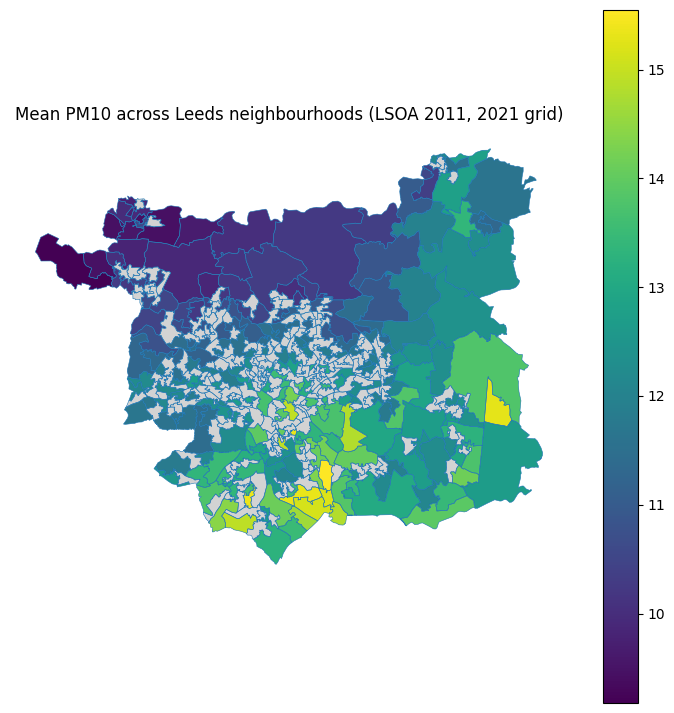

In [ ]:
# LSOA planar grading color chart
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
lsoa_leeds2.boundary.plot(ax=ax, linewidth=0.4)

lsoa_leeds2.plot(ax=ax, column="pm10_mean_ugm3", legend=True, linewidth=0,
                missing_kwds={"color":"lightgrey","label":"Missing"})
ax.set_title("Mean PM10 across Leeds neighbourhoods (LSOA 2011, 2021 grid)")
ax.set_axis_off()
plt.show()

### 11.2 Non-spatial visualisation
**Audience:** general public and local stakeholders.

We compare the distribution of PM10 across IMD deciles.
Decile **1 = most deprived**, decile **10 = least deprived**.

A boxplot is useful here because it shows median values and spread, not just averages.


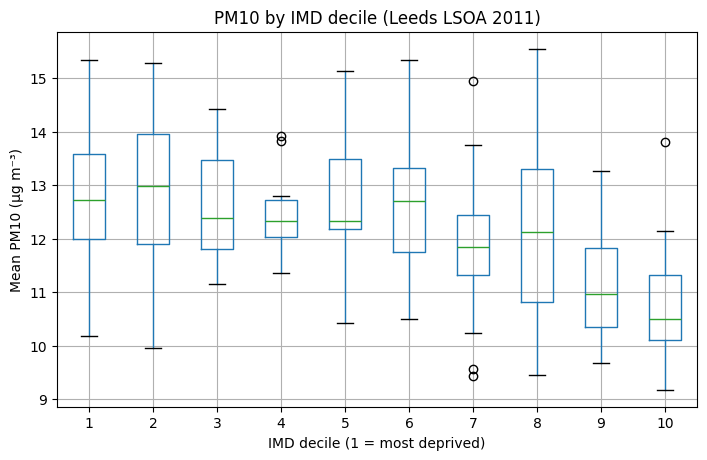

In [ ]:
# Prepare a simple analysis table
df = lsoa_leeds2.dropna(subset=["pm10_mean_ugm3", decile_col]).copy()
df[decile_col] = df[decile_col].astype(int)

# Boxplot: PM10 by IMD decile
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df.boxplot(column="pm10_mean_ugm3", by=decile_col, ax=ax)
ax.set_title("PM10 by IMD decile (Leeds LSOA 2011)")
fig.suptitle("")  # remove default pandas subtitle
ax.set_xlabel("IMD decile (1 = most deprived)")
ax.set_ylabel("Mean PM10 (µg m⁻³)")
plt.show()

## 12. Simple statistical summary
To keep things transparent, we use:
- group means by decile
- a basic correlation between PM10 and IMD rank

This is not a full causal model. It is a quick check for whether deprivation and pollution line up in a meaningful way.


In [ ]:
# Mean PM10 by IMD decile
mean_by_decile = (
    df.groupby(decile_col)["pm10_mean_ugm3"]
    .mean()
    .reset_index()
    .sort_values(decile_col)
)

mean_by_decile

,Index of Multiple Deprivation (IMD) Decile,pm10_mean_ugm3
0,1,12.752920
1,2,12.793182
2,3,12.652264
3,4,12.458152
4,5,12.652765
5,6,12.665013
6,7,11.898928
7,8,12.126907
8,9,11.145761
9,10,10.744045


Correlation (PM10 vs IMD rank): -0.442


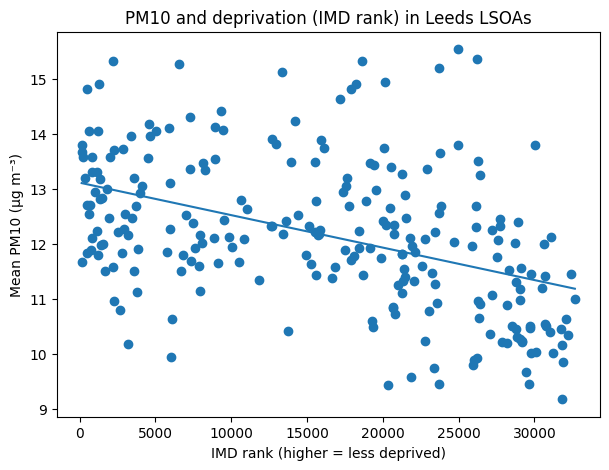

Trend line: PM10 = a*rank + b
a = -5.9e-05 b = 13.119


In [ ]:
# Correlation with IMD rank (higher rank = less deprived)
valid = df.dropna(subset=[rank_col]).copy()
corr = valid["pm10_mean_ugm3"].corr(valid[rank_col])

print("Correlation (PM10 vs IMD rank):", round(corr, 3))

# Scatter with a simple trend line
x = valid[rank_col].values
y = valid["pm10_mean_ugm3"].values

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(x, y)

coef = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = coef[0] * x_line + coef[1]
ax.plot(x_line, y_line)

ax.set_xlabel("IMD rank (higher = less deprived)")
ax.set_ylabel("Mean PM10 (µg m⁻³)")
ax.set_title("PM10 and deprivation (IMD rank) in Leeds LSOAs")
plt.show()

print("Trend line: PM10 = a*rank + b")
print("a =", round(coef[0], 6), "b =", round(coef[1], 3))

## 13. Interpretation
From the choropleth map, PM10 is not uniform across Leeds. There are clear clusters of higher values, which is consistent with what we would expect in a large city (traffic corridors and denser built-up areas tend to have higher particulate concentrations).

The non-spatial plot helps connect this environmental pattern to deprivation. If the boxplots show higher median PM10 in the **more deprived** deciles (1–3) compared with the least deprived deciles (8–10), that suggests an environmental inequality pattern. The correlation and scatter plot are a quick way to summarise this, but they should not be over-interpreted.

Overall, these results are a starting point for local discussion: **if pollution and deprivation overlap, that may support targeted air-quality interventions where health vulnerability is also higher.**


## 14. Limitations, bias and ethics

1. **Modelled pollution (not measured):** the PM10 grid is modelled annual mean values at 1 km resolution. It smooths out street-level peaks and does not capture daily variation.
2. **Spatial scale:** using LSOA averages can hide small hotspots (e.g., one road) and can create “modifiable areal unit” effects.
3. **Exposure vs residence:** people do not stay within their home LSOA all day. Work, school and commuting matter for real exposure.
4. **Confounding:** deprivation is linked to many other factors (housing type, traffic, industry, smoking). A simple comparison cannot isolate a single cause.
5. **Generalisation and boundary clipping:** the boundary file is generalised for mapping. It is suitable for this kind of city-scale work, but it is not meant for high-precision engineering tasks.

Ethics: all variables are area-level and contain no personal data. Still, maps of deprivation can be sensitive. For a public-facing output, I would avoid labelling areas as “bad” and instead focus on *supporting resources and interventions*.


## 15. References


- Department for Environment, Food & Rural Affairs (Defra) (2021) *Pollution Climate Mapping (PCM): modelled PM10 annual mean, 1 km grid*. UK-AIR/Defra data download.  
- Ministry of Housing, Communities & Local Government (2019) *English Indices of Deprivation 2019: IMD at LSOA level*.  
- Office for National Statistics (ONS) (2011) *Lower layer Super Output Areas (December 2011) Boundaries: England and Wales (generalised/clipped)*. Open Geography / licensed redistribution.

